In [18]:
from datetime import datetime

import pandas
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold, cross_val_score
import matplotlib.pyplot as plt
import numpy as np


def get_personal_columns(column_name):
  r_columns = ['r{}_{}'.format(i, column_name) for i in range(1, 6)]
  d_columns = ['d{}_{}'.format(i, column_name) for i in range(1, 6)]
  return r_columns, d_columns


def replace_with_mean(columns, X):
  X_copy = X.copy()
  for column in columns:
    r_columns, d_columns = get_personal_columns(column)
    X_copy['r_mean_{}'.format(column)] = X_copy.loc[:, r_columns].mean(axis=1)
    X_copy['d_mean_{}'.format(column)] = X_copy.loc[:, d_columns].mean(axis=1)
    X_copy = X_copy.drop([*r_columns, *d_columns], axis=1)
  return X_copy


def replace_with_bag_of_words(X, column='hero', file='heroes.csv'):
  words_df = pandas.read_csv('data/dictionaries/{}'.format(file))
  X_words = np.zeros((X.shape[0], len(words_df)))
  for i, match_id in enumerate(X.index):
    for p in range(1, 6):
      X_words[i, X.loc[match_id, 'r{}_{}'.format(p, column)] - 1] = 1
      X_words[i, X.loc[match_id, 'd{}_{}'.format(p, column)] - 1] = -1
  r_columns, d_columns = get_personal_columns(column)
  X_cleaned = X.drop([*r_columns, *d_columns], axis=1)
  words_columns = ['{}_{}'.format(column, i) for i in range(len(words_df))]
  X_words = pandas.DataFrame(X_words, index=X.index, columns=words_columns)
  return pandas.concat([X_cleaned, X_words], axis=1)

def prepare_data(X):
  X_prepared = X.drop(['start_time', 'lobby_type', 'first_blood_time', 'first_blood_player1', 'first_blood_player2'], axis=1)
  X_prepared = X_prepared.fillna(0)
  return replace_with_mean(['gold', 'xp', 'lh', 'kills', 'deaths', 'level', 'items'], X_prepared)


def plot(estimators, scores):
  plt.plot(estimators, scores)
  plt.xlabel('n_estimators')
  estimators30_score = scores[estimators.index(30)]
  plt.scatter(30, estimators30_score, marker='o', c='r')
  plt.annotate('Score with 30 estimators is {:0.3f}'.format(estimators30_score), (30, estimators30_score))
  plt.ylabel('score')
  plt.show()


def get_data(test=False, sample=True, frac=0.5):
  data = pandas.read_csv('data/features{}.csv'.format('_test' if test else ''), index_col='match_id')
  return data if not sample else data.sample(frac=frac)


def get_skips_df(X):
  cols_with_skips = X.loc[:, X.isnull().any()]
  return cols_with_skips.apply(lambda c: c.isnull().sum()).to_frame("skips_count")


% matplotlib inline


### Columns with skips analysis
All this columns are about the actions that may not be happened in the first 5 minutes of the game(or never if the team is very seak).

In [19]:
train_data = get_data()
test_data = get_data(test=True, sample=False)

X_train = train_data[train_data.columns.intersection(test_data.columns.values)]
get_skips_df(X_train)

,skips_count
first_blood_time,9813
first_blood_team,9813
first_blood_player1,9813
first_blood_player2,22090
radiant_bottle_time,7807
radiant_courier_time,348
radiant_flying_courier_time,13744
radiant_first_ward_time,878
dire_bottle_time,8007
dire_courier_time,349


### Data manipulation
By executing many tests I found out that using mean of the features given for every hero improve the quality up to 10%, so at this step I replace this columns with common mean(except the column with info about hero beacuse this info is individually important) and delete the unnecessary columns. I filled nan values with zeros. And after that I replace info about the hero with the bag of words - that's realy useful.

In [20]:
X_train = replace_with_bag_of_words(prepare_data(X_train))
X_train.head()

,first_blood_team,radiant_bottle_time,radiant_courier_time,radiant_flying_courier_time,radiant_tpscroll_count,radiant_boots_count,radiant_ward_observer_count,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,...,hero_102,hero_103,hero_104,hero_105,hero_106,hero_107,hero_108,hero_109,hero_110,hero_111
match_id,,,,,,,,,,,,,,,,,,,,,
41692,0.0,107.0,-85.0,0.0,2,3,2,0,28.0,119.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59494,1.0,28.0,-87.0,185.0,2,4,4,1,-35.0,166.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
7460,0.0,145.0,-84.0,0.0,1,2,2,2,20.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
57827,1.0,7.0,-87.0,198.0,5,4,4,1,-3.0,105.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
36517,0.0,272.0,-82.0,0.0,3,5,2,0,-3.0,107.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Extract the column with the target variable

In [21]:
y = train_data['radiant_win']
y

match_id
41692     0
59494     1
7460      1
57827     0
36517     1
62186     0
76754     0
61058     0
100043    0
88965     1
58958     0
59683     0
34935     0
83633     0
114248    1
36088     1
6487      0
60306     1
6645      0
35971     0
92296     1
33277     1
42338     0
13676     1
70670     0
77037     1
93394     0
43119     1
35696     1
7273      1
         ..
59542     0
44633     1
105970    0
4350      0
73464     1
62574     1
13602     1
88531     1
82291     0
64865     1
34916     0
38659     0
85924     1
5810      1
59799     1
101885    1
6009      0
7908      1
19481     0
34134     0
104662    0
102210    1
67142     1
12763     1
76015     1
60011     1
87017     0
90875     1
101093    0
2626      1
Name: radiant_win, Length: 48615, dtype: int64

Here I tried different number of estimators in order to check whether the algorithm is improved with this number's growth or not. The quality of the classifier was measured with cross validation score by 5 folds using AUC-ROC metrics.

In [22]:
estimators = [10, 20, 30, 70, 120, 250]
scores = []
cross_val_times = []
for n_estimators in estimators:
    cv = KFold(n_splits=5, shuffle=True, random_state=241)
    clf = GradientBoostingClassifier(n_estimators=n_estimators, random_state=241)
    start_time = datetime.now()
    score = cross_val_score(estimator=clf, cv=cv, X=X_train, y=y, scoring='roc_auc').mean()
    cross_val_times.append(datetime.now() - start_time)
    scores.append(score)

Time spent for the estimating cross value score with 30 estimators:

In [23]:
cross_val_times[estimators.index(30)].total_seconds()

31.502845

Finally I plotted the graph in order to visualize changing of the quality score according to the number of estimators.

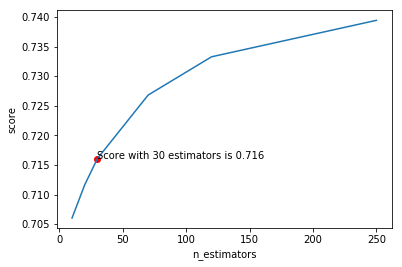

In [24]:
plot(estimators, scores)

As you see on the graph using more trees(n_estimators) increases the quality a lot. So it's very useful to use more than 30 trees.